In [1]:
import sys
print(sys.version)


3.10.16 (main, Dec  3 2024, 17:27:57) [Clang 16.0.0 (clang-1600.0.26.4)]


In [2]:
!pip install numpy pandas matplotlib scikit-learn tensorflow


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 5.8 MB/s eta 0:00:00 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 5.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 19.6 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 29.4 MB/s eta 0:00:00
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 24.5 MB/s eta 0:00:00a 0:00:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


np.random.seed(42)
tf.random.set_seed(42)


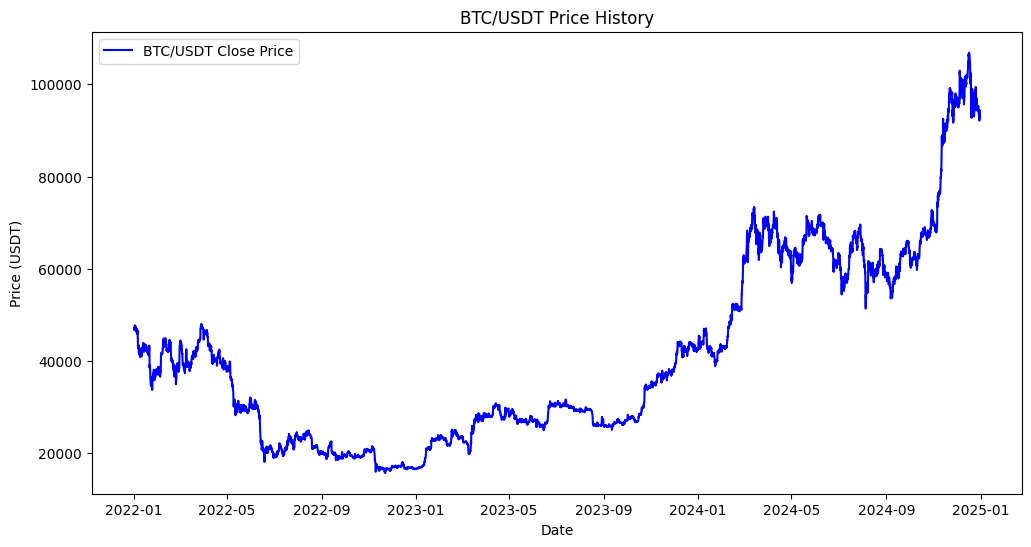

In [4]:

file_path = "BTC_4H_Updated_Data_with_ATR___Daily_Open_Close.csv"  # Ensure correct path
df = pd.read_csv(file_path)


df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)


btc_prices = df[['Close']]


plt.figure(figsize=(12, 6))
plt.plot(btc_prices, label="BTC/USDT Close Price", color='blue')
plt.xlabel("Date")
plt.ylabel("Price (USDT)")
plt.title("BTC/USDT Price History")
plt.legend()
plt.show()


In [5]:

scaler = MinMaxScaler(feature_range=(0, 1))
btc_prices_scaled = scaler.fit_transform(btc_prices)


btc_prices_scaled = pd.DataFrame(btc_prices_scaled, index=btc_prices.index, columns=['Close'])


In [6]:

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)


lookback = 50
X, y = create_sequences(btc_prices_scaled.values, lookback)


split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]


print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (5216, 50, 1), y_train shape: (5216, 1)
X_test shape: (1304, 50, 1), y_test shape: (1304, 1)


In [7]:

model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.2),
    LSTM(100, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer (predicting one value)
])


model.compile(optimizer='adam', loss='mean_squared_error')


model.summary()


/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: 0.0091 - val_loss: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 7.7478e-04 - val_loss: 8.8789e-04
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 7.1681e-04 - val_loss: 4.7834e-04
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 5.7504e-04 - val_loss: 5.7008e-04
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 5.2189e-04 - val_loss: 5.4714e-04
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 4.7827e-04 - val_loss: 6.1682e-04
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 4.5050e-04 - val_loss: 7.9691e-04
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 4.4813e-04 - val_loss: 5.9278e-04
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 3.7174e-04 - val_loss: 3.5090e-04
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 3.9205e-04 - val_loss: 6.2692e-04
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - 

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


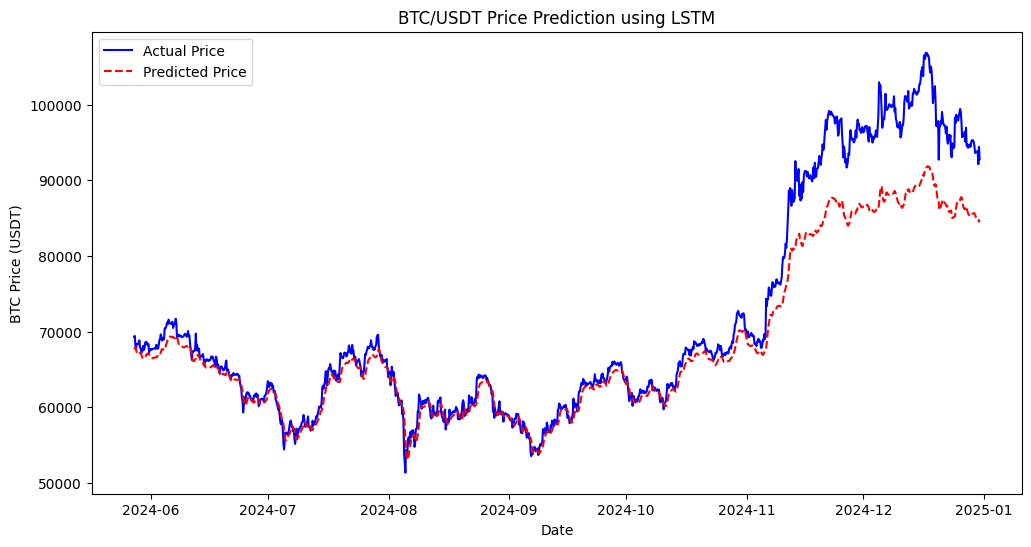

In [9]:

y_pred = model.predict(X_test)

# Reverse scaling to get actual price values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)


plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual Price", color='blue')
plt.plot(df.index[-len(y_pred_actual):], y_pred_actual, label="Predicted Price", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("BTC Price (USDT)")
plt.title("BTC/USDT Price Prediction using LSTM")
plt.legend()
plt.show()


In [10]:
from sklearn.metrics import mean_squared_error


rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 5124.278342891794


In [19]:
y_pred = model.predict(X_test)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [20]:
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))


In [21]:
from sklearn.metrics import mean_absolute_error

# MAE Calculation
mae = mean_absolute_error(y_test_original, y_pred_original)

# MAPE Calculation
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 3152.65
MAPE: 3.66%
